In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import string
import matplotlib as mpl
import numpy as np
from deeptools import heatmapper as hm
from deeptools import heatmapper_utilities as hu
from deeptools.plotProfile import Profile
from deeptools.heatmapper_utilities import plot_single

%matplotlib inline

from lad_utils import *

# single cell LAD data

From Kind et al. 2015

In [2]:
# load Kind et al. 2015 single cell data
dat = pd.read_csv('kind_et_al/2015/GSE68260_Clone.5-5.1N.OE_LP150415.txt',
                 sep='\t')

# determine percentage of cells with LB1 association at each locus
dat['perc_cells_LB1'] = 100.0 * ((dat[dat.columns[4:-1]] > 0.0).sum(1) / 172.0 )

# liftOver to hg38 from hg19
bed_hg38 = BedTool.from_dataframe(dat[['seqnames','start','end','perc_cells_LB1']]).liftover('/pollard/data/functional_genomics/liftOver/hg19ToHg38.over.chain.gz').sort()

n_states = 3

# Paraxial mesoderm is the closest cell type we have
lb1_dat = pd.read_table(f'LB1_HMM_predictions/LB1_dat_{n_states}state.tsv')
lb1_dat = assign_categories(lb1_dat.copy(), cat_names=['nonLAD','T2-LAD','T1-LAD'])
lb1_dat['id'] = lb1_dat.index
lb1_dat_bed = BedTool.from_dataframe(lb1_dat[['chrom','start','stop','id']]).sort()

# intersect LB1 bins with single cell data
lb1_scdat = lb1_dat_bed.intersect(bed_hg38, wa=True, wb=True).to_dataframe()[['name','thickEnd']]
lb1_scdat.columns = ['id','perc_cells_LB1']

# merge back to LB1 data
lb1_w_sc = lb1_dat.merge(lb1_scdat, on='id', how='left').fillna(0.0)

# CTCF data

#### T1-LADs

generated using output from deepTools

bin size: 1kb
window size (up and downstream) : 200kb
region body length: scaled to 100kb

`computeMatrix scale-regions -S CTCF/GSE116862/H9ESC/GSM3263064_CTCF_D00_Rep1_hg38.rpkm.bw CTCF/GSE116862/H9ESC/GSM3263065_CTCF_D00_Rep2_hg38.rpkm.bw CTCF/GSE116862/D2Mesoderm/GSM3263066_CTCF_D02_Rep1_hg38.rpkm.bw.bw CTCF/GSE116862/D2Mesoderm/GSM3263067_CTCF_D02_Rep2_hg38.rpkm.bw.bw CTCF/GSE116862/VCM/GSM3263074_CTCF_D80_Rep1_hg38.rpkm.bw.bw -R LADs_3state/H9ESC_T1LAD.bed LADs_3state/ParaxMesoderm_T1LAD.bed LADs_3state/CardiacMyocytes_T1LAD.bed -m 100000 -a 200000 -b 200000 -bs 100 -o CTCF/ctcf_t1lads.gz --missingDataAsZero -p 20 --outFileNameMatrix CTCF/ctcf_t1lads.tsv --samplesLabel H9ESC_rep1_CTCF H9ESC_rep2_CTCF D2Mesoderm_rep1_CTCF D2Mesoderm_rep1_CTCF VCM_CTCF`

`plotProfile -m CTCF/ctcf_t1lads.gz --outFileName CTCF/t1lads.png --outFileNameData CTCF/ctcf_t1lads_for_plot.tsv --regionsLabel H9ESC ParaxMesoderm CardiacMyocytes`

#### T2-LADs

`computeMatrix scale-regions -S CTCF/GSE116862/H9ESC/GSM3263064_CTCF_D00_Rep1_hg38.rpkm.bw CTCF/GSE116862/H9ESC/GSM3263065_CTCF_D00_Rep2_hg38.rpkm.bw CTCF/GSE116862/D2Mesoderm/GSM3263066_CTCF_D02_Rep1_hg38.rpkm.bw.bw CTCF/GSE116862/D2Mesoderm/GSM3263067_CTCF_D02_Rep2_hg38.rpkm.bw.bw CTCF/GSE116862/VCM/GSM3263074_CTCF_D80_Rep1_hg38.rpkm.bw.bw -R LADs_3state/H9ESC_T2LAD.bed LADs_3state/ParaxMesoderm_T2LAD.bed LADs_3state/CardiacMyocytes_T2LAD.bed -m 100000 -a 200000 -b 200000 -bs 100 -o CTCF/ctcf_t2lads.gz -p 20 --outFileNameMatrix CTCF/ctcf_t2lads.tsv --samplesLabel H9ESC_rep1_CTCF H9ESC_rep2_CTCF D2Mesoderm_rep1_CTCF D2Mesoderm_rep1_CTCF VCM_CTCF`

`plotProfile -m CTCF/ctcf_t2lads.gz --outFileName CTCF/t2lads.png --outFileNameData CTCF/ctcf_t2lads_for_plot.tsv --regionsLabel H9ESC ParaxMesoderm CardiacMyocytes`

In [2]:
def load_ctcf_dat(path, rtype):
    ctcf = pd.read_table(path,
                         skiprows=1, header=0, low_memory=False).replace(np.nan, 0.0)
    ctcf.columns = ['CTCF',rtype] + list(range(ctcf.shape[1]))[:-2]
    ctcf.columns = ['CTCF',rtype] + list(range(ctcf.shape[1]))[:-2]

    dfs = []

    for ix, row in ctcf.iterrows():
        CTCF_dset = row['CTCF']
        r_dset = row[rtype]

        dat = pd.DataFrame(row[2:].T)
        dat.columns=['CTCF_sig']
        dat['CTCF'] = CTCF_dset.split('_')[0]
        dat[rtype] = r_dset.split('_')[0]
        dat['bin'] = dat.index

        dfs.append(dat)


    ctcf_tog = pd.concat(dfs, sort=False)
    ctcf_tog['CTCF_sig'] = ctcf_tog['CTCF_sig'].astype(float)
    return(ctcf_tog)

In [3]:
t1lads_ctcf_tog = load_ctcf_dat('CTCF/ctcf_t1lads_for_plot.tsv','T1LADs')

In [4]:
t1lads_ctcf_tog.head()

,CTCF_sig,CTCF,T1LADs,bin
0,0.706872,H9ESC,H9ESC,0
1,0.665670,H9ESC,H9ESC,1
2,0.661981,H9ESC,H9ESC,2
3,0.703163,H9ESC,H9ESC,3
4,0.657284,H9ESC,H9ESC,4


In [5]:
t2lads_ctcf_tog = load_ctcf_dat('CTCF/ctcf_t2lads_for_plot.tsv','T2LADs')

# TEs and RT domains

In [6]:
# this is generated by the HMM

lb1_dat = pd.read_table('LB1_HMM_predictions/LB1_dat_3state.tsv').reset_index()

lb1_dat['id'] = lb1_dat.index
lb1_dat['LB1_median'] = lb1_dat[['score0','score1']].median(axis=1)
lb1_dat_bed = BedTool.from_dataframe(lb1_dat[['chrom','start','stop','id']])
lb1_dat = assign_categories(lb1_dat.copy(), cat_names=['nonLAD','T2-LAD','T1-LAD'])

In [7]:
def get_enrichment(feature, dat):
    ors = []
    pvals = []
    cats = []

    for cat in dat['category'].unique():

        counts = np.array([[len(dat.query(f'{feature} and category == @cat')),
                  len(dat.query(f'~{feature} and category == @cat'))],
                 [len(dat.query(f'{feature} and category != @cat')),
                  len(dat.query(f'~{feature} and category != @cat'))]])

        odds, pval = stats.fisher_exact(counts)
        ors.append(odds)
        pvals.append(pval)
        cats.append(cat)

    out = pd.DataFrame({
        'odds_ratio':ors,
        'fishers_p':pvals,
        'cat':cats
    })
    
    return(out)

In [8]:
rt_df = pd.read_csv('replication_timing/constitutive_dev_domains/hg38_labels_NatGenetics2018/Human_NormalCellTypes_48datasets_hg38_50KB-qunatilescaled_label_0.15_threshold.txt',
                sep='\t')

rt_df['switch'] = rt_df['switch'].replace(np.nan, 'NA')
rt_df['END'] = rt_df['POS'] + 50000

switch_domains = BedTool.from_dataframe(rt_df.query('switch == "S"').copy()[['CHR','POS','END','switch']])
cl_domains = BedTool.from_dataframe(rt_df.query('switch == "CL"').copy()[['CHR','POS','END','switch']])
ce_domains = BedTool.from_dataframe(rt_df.query('switch == "CE"').copy()[['CHR','POS','END','switch']])
unclassified = BedTool.from_dataframe(rt_df.query('switch == "NA"').copy()[['CHR','POS','END','switch']])

lb1_switch = lb1_dat_bed.intersect(switch_domains, u=True).to_dataframe()['name'].drop_duplicates().tolist()
lb1_cl = lb1_dat_bed.intersect(cl_domains, u=True).to_dataframe()['name'].drop_duplicates().tolist()
lb1_ce = lb1_dat_bed.intersect(ce_domains, u=True).to_dataframe()['name'].drop_duplicates().tolist()

lb1_dat['overlaps_switch'] = lb1_dat['id'].isin(lb1_switch)
lb1_dat['overlaps_cl'] = lb1_dat['id'].isin(lb1_cl)
lb1_dat['overlaps_ce'] = lb1_dat['id'].isin(lb1_ce)

In [9]:
te_dat = pd.read_csv('repeatmasker.txt.gz',
                    sep='\t', compression='gzip')

In [10]:
for family in ['L1','Alu','SVA']:
    te_bed = BedTool.from_dataframe(te_dat.query('repFamily == @family')[['genoName','genoStart','genoEnd','id']]).sort()
    lb1_te = lb1_dat_bed.intersect(te_bed, u=True).to_dataframe()['name'].drop_duplicates().tolist()
    lb1_dat[f'overlaps_{family}'] = lb1_dat['id'].isin(lb1_te)
    
for te_class in ['LINE','SINE']:
    te_bed = BedTool.from_dataframe(te_dat.query('repClass == @te_class')[['genoName','genoStart','genoEnd','id']]).sort()
    lb1_te = lb1_dat_bed.intersect(te_bed, u=True).to_dataframe()['name'].drop_duplicates().tolist()
    lb1_dat[f'overlaps_{te_class}'] = lb1_dat['id'].isin(lb1_te)
    
    

In [11]:
with open('tier_one_cts.txt','r') as f:
    tier_one_cts = f.read().splitlines()

In [12]:
enrichment_dfs = []

for ct in tier_one_cts:
    for feature in ['switch','cl','ce','L1','Alu','SVA','LINE','SVA','SINE']:
        enrichment_df = get_enrichment(f'overlaps_{feature}', lb1_dat.query('cell_type == @ct'))
        enrichment_df['enr_type'] = feature
        enrichment_df['cell_type'] = ct
        enrichment_dfs.append(enrichment_df)
    
enrichments_overall = pd.concat(enrichment_dfs, sort=False)

In [13]:
enrichments_overall['neg_log10_p'] = -enrichments_overall['fishers_p'].map(np.log10)
enrichments_overall = enrichments_overall.replace(np.inf, 300)

In [88]:
enrichments_overall.head()

,odds_ratio,fishers_p,cat,enr_type,cell_type,neg_log10_p
0,1.074381,3.184575e-12,nonLAD,switch,CardiacMyocytes,11.496949
1,1.182212,1.391222e-40,T2-LAD,switch,CardiacMyocytes,39.856604
2,0.820849,1.370764e-76,T1-LAD,switch,CardiacMyocytes,75.863037
0,0.039422,0.000000e+00,nonLAD,cl,CardiacMyocytes,300.000000
1,0.356979,0.000000e+00,T2-LAD,cl,CardiacMyocytes,300.000000


In [89]:
enrichments_overall.columns

Index(['odds_ratio', 'fishers_p', 'cat', 'enr_type', 'cell_type',
       'neg_log10_p'],
      dtype='object')

In [14]:
enrichments_overall.columns = ['odds_ratio', 'fishers_p', 
                               'LAD type', 'enr_type', 
                               'cell type','-log10(P-value)']

In [15]:
te_replace = {
    'L1':'L1 (LINE)',
    'Alu':'Alu (SINE)',
    'SVA':'SVA (Retroposon)'
}

# main figure

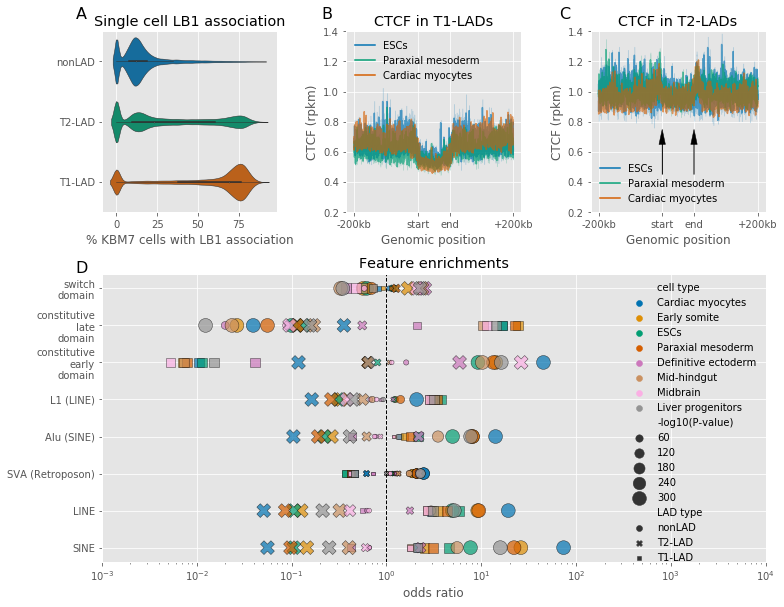

In [16]:
plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')

fig = plt.figure(figsize=(11,8.5))

plt.subplots_adjust(hspace=0.5, wspace=0.3)

lw = 0.5 # linewidth

gs = mpl.gridspec.GridSpec(3, 3, width_ratios=[1, 1, 1],
                          height_ratios=[1,0.75,0.5])

# panel A

axA = plt.subplot(gs[0,0])

sns.violinplot(y='category', x='perc_cells_LB1', 
               data=lb1_w_sc.replace(ct_replace), #sc_dat from LADs and LADlites vs. sc data
              ax=axA, order=['nonLAD','T2-LAD','T1-LAD'], linewidth=lw)

axA.set(xlabel='% KBM7 cells with LB1 association', ylabel='', 
        title='Single cell LB1 association')

# panel B 

axB = plt.subplot(gs[0,1])

sns.lineplot(x='bin', y='CTCF_sig', data=t1lads_ctcf_tog.query('(bin < 5000)'\
                                                   ' and (((CTCF == '\
                                                   '"H9ESC") and '\
                                                   '(T1LADs == '\
                                                   '"H9ESC")) or ((CTCF == '\
                                                   '"D2Mesoderm") and '\
                                                   '(T1LADs == '\
                                                   '"ParaxMesoderm")) or '\
                                                  '((CTCF == '\
                                                   '"VCM") and '\
                                                   '(T1LADs == '\
                                                   '"CardiacMyocytes")))').replace(ct_replace).replace('T1LADs','T1-LADs'),
            ax=axB, hue='T1LADs', alpha=0.6, hue_order=['ESCs','Paraxial mesoderm','Cardiac myocytes'])

axB.set_xticks([0, 2000, 3000, 5000])
axB.set_xticklabels(['-200kb','start','end','+200kb'])
axB.set(xlabel='Genomic position', ylabel='CTCF (rpkm)', 
        title='CTCF in T1-LADs', ylim=(0.2,1.4))

axB.legend(loc='upper left', frameon=False)

# panel C 

axC = plt.subplot(gs[0,2])

sns.lineplot(x='bin', y='CTCF_sig', data=t2lads_ctcf_tog.query('(bin < 5000)'\
                                                   ' and (((CTCF == '\
                                                   '"H9ESC") and '\
                                                   '(T2LADs == '\
                                                   '"H9ESC")) or ((CTCF == '\
                                                   '"D2Mesoderm") and '\
                                                   '(T2LADs == '\
                                                   '"ParaxMesoderm")) or '\
                                                  '((CTCF == '\
                                                   '"VCM") and '\
                                                   '(T2LADs == '\
                                                   '"CardiacMyocytes")))').replace(ct_replace).replace('T1LADs','T1-LADs'),
            ax=axC, hue='T2LADs', alpha=0.6, hue_order=['ESCs','Paraxial mesoderm','Cardiac myocytes'])

axC.set_xticks([0, 2000, 3000, 5000])
axC.set_xticklabels(['-200kb','start','end','+200kb'])
axC.set(xlabel='Genomic position', ylabel='CTCF (rpkm)', 
        title='CTCF in T2-LADs', ylim=(0.2,1.4))

axC.arrow(2000, 0.45, 0, 0.2, head_width=200, head_length=0.1, fc='k', ec='k')

axC.arrow(3000, 0.45, 0, 0.2, head_width=200, head_length=0.1, fc='k', ec='k')

axC.legend(loc='lower left', frameon=False)

# panel D: feature enrichments

axD = plt.subplot(gs[1:3, 0:3])

sns.scatterplot(y='enr_type', x='odds_ratio', data=enrichments_overall.replace(ct_replace).replace({
    'switch':'switch\ndomain',
    'cl':'constitutive\nlate\ndomain',
    'ce':'constitutive\nearly\ndomain'}).replace(te_replace),
               size='-log10(P-value)', palette='colorblind',
                style='LAD type', hue='cell type', sizes=(20, 200),
                ax=axD, linewidth=lw, edgecolor='black', alpha=0.7)

axD.set(xscale='log', xlabel='odds ratio', xlim=(0.001, 10000),
       title='Feature enrichments', ylabel='')
axD.axvline(1, linestyle='dashed', color='black', linewidth=2*lw)
axD.legend(loc='upper right', frameon=False)

fig.text(0.1, 0.975, 'A', fontsize=16,
         ha='left')
fig.text(0.41, 0.975, 'B', fontsize=16,
         ha='left')
fig.text(0.71, 0.975, 'C', fontsize=16,
         ha='left')
fig.text(0.1, 0.56, 'D', fontsize=16,
         ha='left')

fig.tight_layout()

In [17]:
fig.savefig('../figs/r2r_fig3_mechanism_low_res.png',
           dpi=100, bbox_inches='tight')

In [103]:
fig.savefig('../figs/r2r_fig3_mechanism.png',
           dpi=300, bbox_inches='tight')